In [55]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

import os
import numpy as np
from os import listdir
from pathlib import Path
from scipy.io import loadmat
from sklearn.model_selection import train_test_split
import h5py
import pydicom as dicom
import matplotlib.pyplot as plt
from dicompylercore import dicomparser, dvh, dvhcalc
from dicom_contour.contour import get_contour_file,get_roi_names, coord2pixels, cfile2pixels, plot2dcontour, slice_order, get_contour_dict, get_data,  create_image_mask_files
from preprocessing.get_plan_from_dicom import Plan, plot_DVH, structure_range, img_cut, resample
from preprocessing.get_plan_from_dicom import plot_3d_img, plan_unit_test
from preprocessing.generate_data import get_plans_unit_test
from util import *
from config import *
from preprocessing.generate_data import get_plans
from dicom_contour.contour import get_ct_name_dict
from dicom_contour.dose import build_dose_volume
import pickle
from PIL import Image, ImageDraw
from copy import deepcopy
import math
#from model_training_evaluation.training import train_nn_model, run_training
from model_training_evaluation.predicting import predict_evaluation, evaluate, predict_batch, predict_unit_test

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [56]:
if __name__ == '__main__':
    dicom_path = './dicom_data'
    plan_save_path = './Data/plans'
    dataset_save_path = './Data/npy_dataset'
    
    get_plans(dicom_path, section = 'Lungs', section_size = section_size, matrix_size = matrix_size, plan_save_path = plan_save_path, dataset_save_path = dataset_save_path, save_npy = True, batch_size = 1)

work on patient  TMI_Evans
work on RS structure  TMLI 17423 Body
start structure extraction
finish extract contour
Elapsed time: 131.0374 seconds
start extract dose
finish extract dose
Elapsed time: 36.1482 seconds
BODY <--------> BODY
PTV_Ribs <--------> PTV_Ribs
PTV_VExP <--------> PTV_VExP
PTV_SpCord <--------> PTV_SpCord
PTV_LN <--------> PTV_LN
PTV_Spleen <--------> PTV_Spleen
PTV_Liver <--------> PTV_Liver
Lungs <--------> Lungs
Heart <--------> Heart
Esophagus <--------> Esophagus
GI_Upper <--------> GI_Upper
Breasts <--------> Breasts
x_dim, y_dim, z_dim [109, 349] [94, 414] [75, 111]
one structure Mask Data Shape: (16, 96, 128, 12)
scan shape and dose shape= (1, 16, 96, 128, 12) (1, 16, 96, 128, 1)
work on patient  TMI_Kane
work on RS structure  CT_TMI_11/18/19
start structure extraction
finish extract contour
Elapsed time: 124.7916 seconds
start extract dose
finish extract dose
Elapsed time: 39.4745 seconds
BODY <--------> BODY
PTV_Ribs <--------> PTV_Ribs
PTV_VExP <-------->

work on RS structure  CT_TMI_11/18/19
start structure extraction
finish extract contour
Elapsed time: 128.2233 seconds
start extract dose
finish extract dose
Elapsed time: 39.5797 seconds
BODY <--------> BODY
PTV_Ribs <--------> PTV_Ribs
PTV_VExP <--------> PTV_VExP
PTV_SpCord <--------> PTV_SpCord
PTV_LN <--------> PTV_LN
PTV_Spleen <--------> PTV_Spleen
PTV_Liver <--------> PTV_Liver
Lungs <--------> Lungs
Heart <--------> Heart
Esophagus <--------> Esophagus
GI_Upper <--------> GI_Upper
dict_keys(['Bladder', 'Esophagus+Mar', 'Eyes', 'Eyes+Margin', 'GI_Lower', 'Kidney_L', 'Kidney_R', 'Kidneys', 'Kidneys+Margin', 'Lenses', 'Lung_L', 'Lung_R', 'OpticN/Chiasm', 'OralCavity', 'Parotids', 'PTV_Brain', 'PTV_Skull', 'PTV_Testes', 'Rectum', 'Thyroid', 'Larynx', 'Avoid-post', 'Avoid-ant', 'Avoid-ant1', 'Skin', 'Ring1', 'BODY', 'PTV_Ribs', 'PTV_VExP', 'PTV_SpCord', 'PTV_LN', 'PTV_Spleen', 'PTV_Liver', 'Lungs', 'Heart', 'Esophagus', 'GI_Upper', 'Breasts'])


<IPython.core.display.Javascript object>


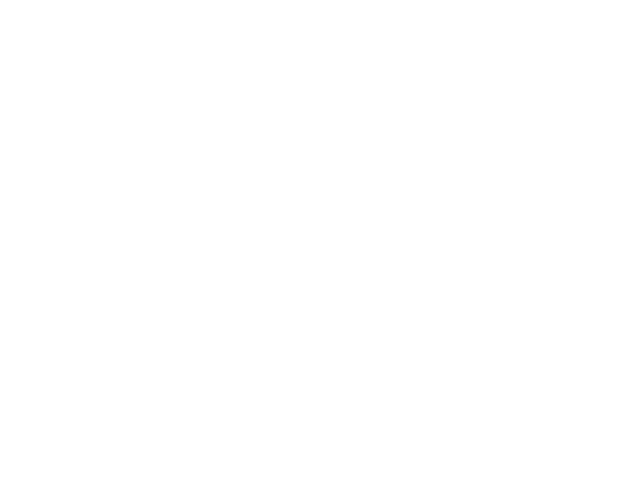

In [14]:
plan = plan_unit_test()

<IPython.core.display.Javascript object>


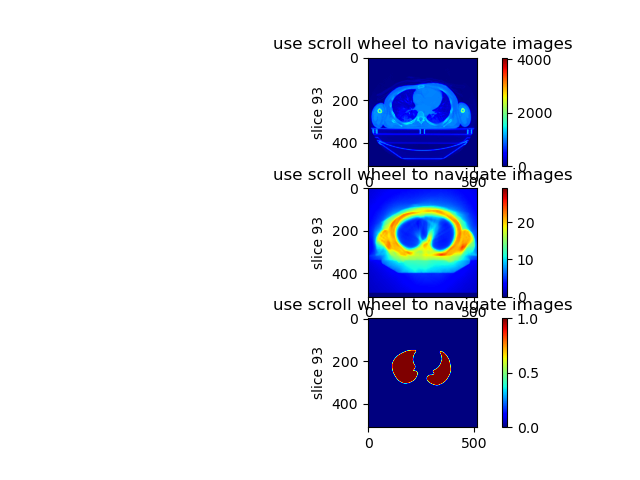

In [27]:
organ = 'Lungs'
fig, (ax1, ax2, ax3)= plt.subplots(3, 1)
max_img = np.max(plan.img_volume.flatten())
max_dose = np.max(plan.dose_volume.flatten())
tracker1 = IndexTracker(ax1, plan.img_volume, fig,0,max_img)
fig.canvas.mpl_connect('scroll_event', tracker1.onscroll)
tracker2 = IndexTracker(ax2, plan.dose_volume, fig,0,max_dose)
fig.canvas.mpl_connect('scroll_event', tracker2.onscroll)
tracker3 = IndexTracker(ax3, plan.structures[organ]['mask'], fig,0,1)
fig.canvas.mpl_connect('scroll_event', tracker3.onscroll)
#tracker4 = IndexTracker(ax4, plan.structures[organ]['contour'], fig,0,1)
#fig.canvas.mpl_connect('scroll_event', tracker4.onscroll)
plt.show()

In [43]:
zmin_body,zmax_body,xmin_body,xmax_body,ymin_body,ymax_body = plan.structure_range('BODY')
section = 'Lungs'
zmin,zmax,xmin,xmax,ymin,ymax = plan.structure_range(section)

origin = [math.floor((zmin+zmax)/2), math.floor((xmin_body+xmax_body)/2), math.floor((ymin_body+ymax_body)/2)]

In [44]:
z_dim = int(section_size[0]*10 / plan.slice_thickness)
x_dim = int(section_size[1]*10 / plan.Row_Spacing); y_dim = int(section_size[2]*10 / plan.Col_Spacing)
plan_test = deepcopy(plan)
print(x_dim, y_dim, z_dim)
print(origin)

384 512 36
[98, 213, 249]


In [40]:
plan.Col_Spacing

0.976562

In [45]:
plan_test.img_cut(x_dim, y_dim, z_dim, origin)

<IPython.core.display.Javascript object>


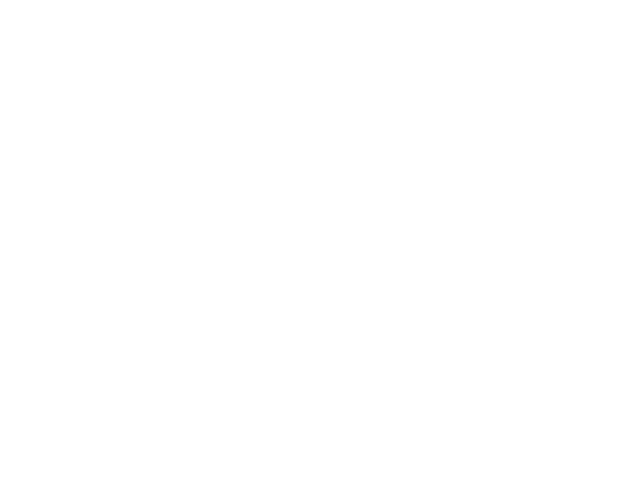

ValueError: zero-size array to reduction operation maximum which has no identity

In [46]:
organ = 'Lungs'
fig, (ax1, ax2, ax3)= plt.subplots(3, 1)
max_img = np.max(plan_test.img_volume.flatten())
max_dose = np.max(plan_test.dose_volume.flatten())
tracker1 = IndexTracker(ax1, plan_test.img_volume, fig,0,max_img)
fig.canvas.mpl_connect('scroll_event', tracker1.onscroll)
tracker2 = IndexTracker(ax2, plan_test.dose_volume, fig,0,max_dose)
fig.canvas.mpl_connect('scroll_event', tracker2.onscroll)
tracker3 = IndexTracker(ax3, plan_test.structures[organ]['mask'], fig,0,1)
fig.canvas.mpl_connect('scroll_event', tracker3.onscroll)
#tracker4 = IndexTracker(ax4, plan.structures[organ]['contour'], fig,0,1)
#fig.canvas.mpl_connect('scroll_event', tracker4.onscroll)
plt.show()

In [20]:
scans, dose_imgs = get_plans_unit_test()

work on patient  TMI_Kane
work on RS structure  CT_TMI_11/18/19
start structure extraction
finish extract contour
Elapsed time: 124.2425 seconds
start extract dose
finish extract dose
Elapsed time: 38.7863 seconds
BODY <--------> BODY
PTV_Ribs <--------> PTV_Ribs
PTV_VExP <--------> PTV_VExP
PTV_SpCord <--------> PTV_SpCord
PTV_LN <--------> PTV_LN
PTV_Spleen <--------> PTV_Spleen
PTV_Liver <--------> PTV_Liver
Lungs <--------> Lungs
Heart <--------> Heart
Esophagus <--------> Esophagus
GI_Upper <--------> GI_Upper
one structure Mask Data Shape: (16, 64, 128, 12)
scan shape and dose shape= (1, 16, 64, 128, 12) (1, 16, 64, 128, 1)
Structure Masks Data Shape: (1, 16, 64, 128, 12)
Dose Data Shape: (1, 16, 64, 128, 1)
NPY dataset saved!
work on patient  TMI_Kane
work on RS structure  CT_TMI_11/18/19
start structure extraction
finish extract contour
Elapsed time: 135.4214 seconds
start extract dose
finish extract dose
Elapsed time: 38.6983 seconds
BODY <--------> BODY
PTV_Ribs <--------> PT

<IPython.core.display.Javascript object>


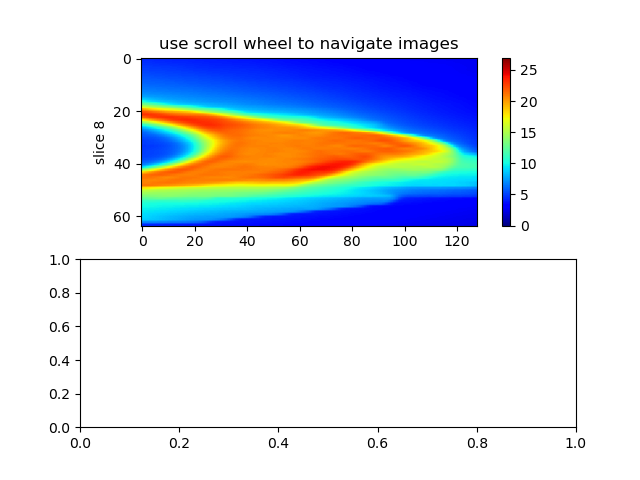

In [25]:
dose = np.squeeze(dose_imgs)
fig, (ax1, ax2)= plt.subplots(2, 1)
max_dose = np.max((dose).flatten())
tracker1 = IndexTracker(ax1, dose, fig,0,max_dose)

In [3]:
plan = pickle.load(open("plan_Chavez.pickle", "rb", -1))

<IPython.core.display.Javascript object>


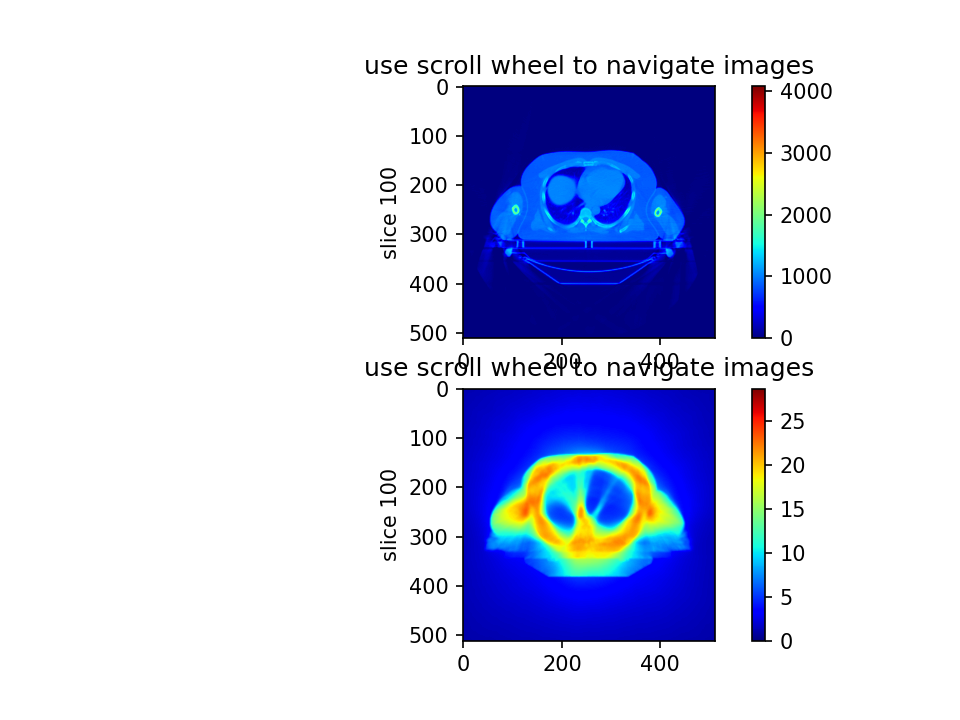

<IPython.core.display.Javascript object>


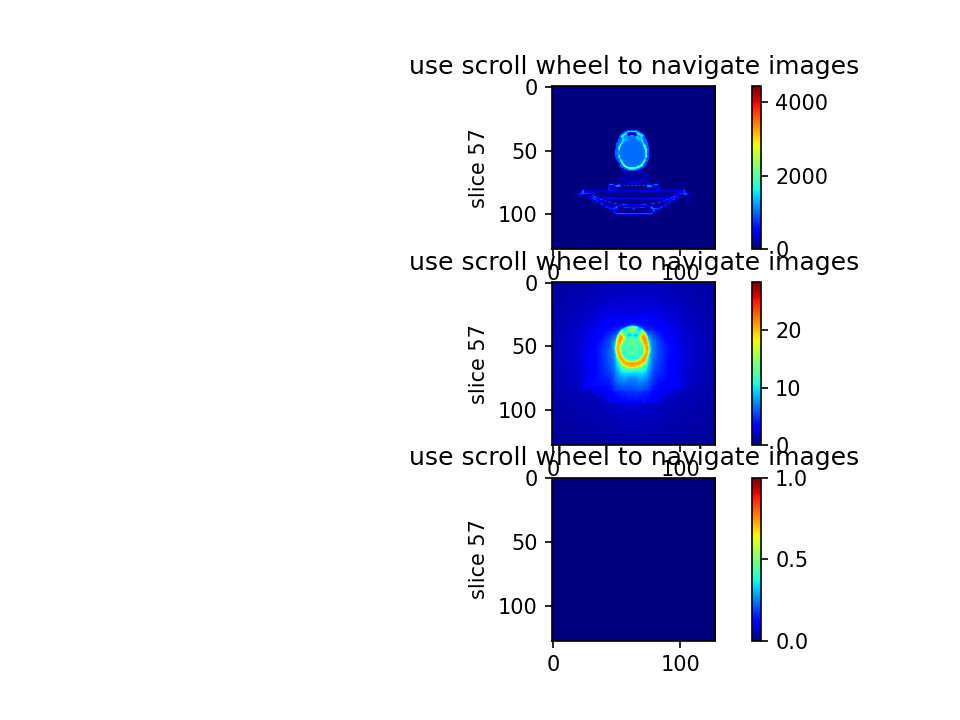

In [203]:
plan_new = deepcopy(plan)
plan_new = resample(plan_new,x_dim=128, y_dim=128, z_dim=64)
organ = 'Lungs'

print('old dimenstion is ', plan.img_volume.shape())
print('new dimenstion is ', plan_new.img_volume.shape())

fig, (ax1, ax2, ax3)= plt.subplots(3, 1)
max_img = np.max(plan_new.img_volume.flatten())
max_dose = np.max(plan_new.dose_volume.flatten())
tracker1 = IndexTracker(ax1, plan_new.img_volume, fig,0,max_img)
fig.canvas.mpl_connect('scroll_event', tracker1.onscroll)
tracker2 = IndexTracker(ax2, plan_new.dose_volume, fig,0,max_dose)
fig.canvas.mpl_connect('scroll_event', tracker2.onscroll)
tracker3 = IndexTracker(ax3, plan_new.structures[organ]['mask'], fig,0,1)
fig.canvas.mpl_connect('scroll_event', tracker3.onscroll)
plt.show()

x_dim:122, y_dim:179, z_dim:29, origin:[104, 221, 255]


<IPython.core.display.Javascript object>


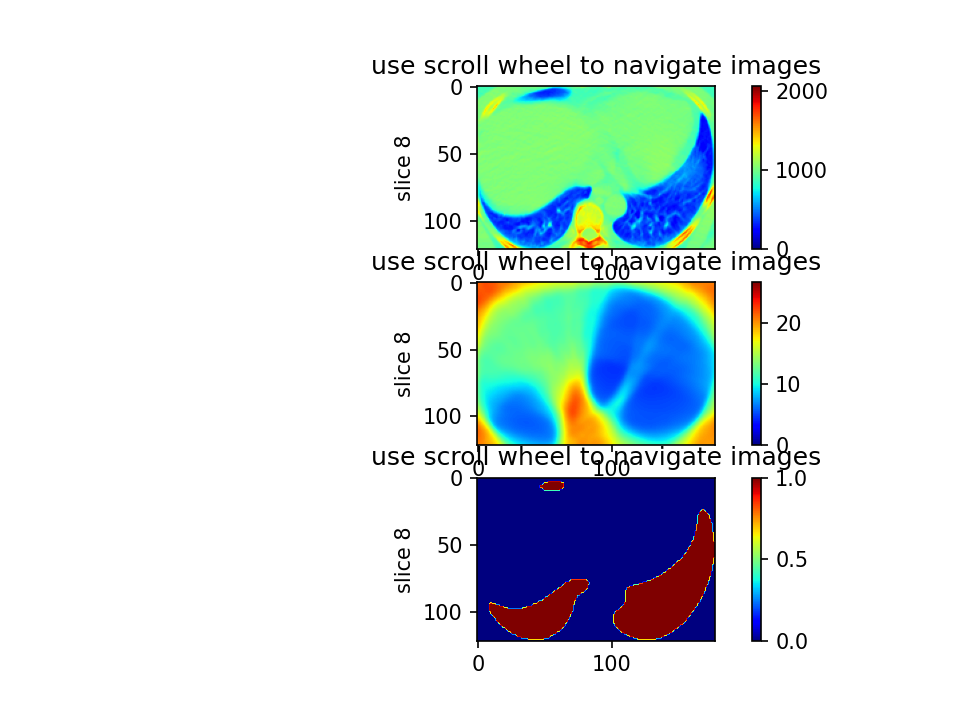

In [192]:
plan_new = deepcopy(plan)
zmin,zmax,xmin,xmax,ymin,ymax = structure_range(plan_new, 'Lungs')
origin = [math.floor((zmin+zmax)/2), math.floor((xmin+xmax)/2), math.floor((ymin+ymax)/2)]
x_dim = xmax-xmin+4; z_dim = zmax-zmin+4; y_dim = ymax-ymin+4
print('x_dim:{}, y_dim:{}, z_dim:{}, origin:{}'.format(x_dim,y_dim,z_dim,origin))
plan_new = img_cut(plan_new, x_dim, y_dim, z_dim, origin)
organ = 'Lungs'

fig, (ax1, ax2, ax3)= plt.subplots(3, 1)
max_img = np.max(plan_new.img_volume.flatten())
max_dose = np.max(plan_new.dose_volume.flatten())
tracker1 = IndexTracker(ax1, plan_new.img_volume, fig,0,max_img)
fig.canvas.mpl_connect('scroll_event', tracker1.onscroll)
tracker2 = IndexTracker(ax2, plan_new.dose_volume, fig,0,max_dose)
fig.canvas.mpl_connect('scroll_event', tracker2.onscroll)
tracker3 = IndexTracker(ax3, plan_new.structures[organ]['mask'], fig,0,1)
fig.canvas.mpl_connect('scroll_event', tracker3.onscroll)
plt.show()

<IPython.core.display.Javascript object>


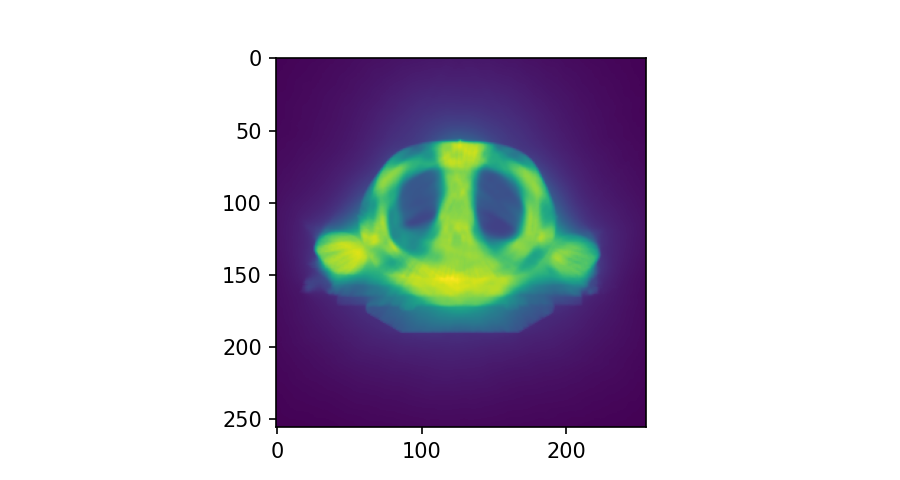

In [118]:
standard_list = ['PTV_Ribs', 'PTV_VExP', 'PTV_SpCord', 'PTV_LN', 'PTV_Spleen', 'PTV_Liver', 'BODY', 'Lungs']
standard_list = ['Heart', 'PTV_SpCord', 'Lung_L','PTV_Skull','Bladder']
plot_DVH(plan, standard_list)

Lungs
True mean organ dose is:  8.015882836100516
True max organ dose is:  26.72603736307324


<IPython.core.display.Javascript object>


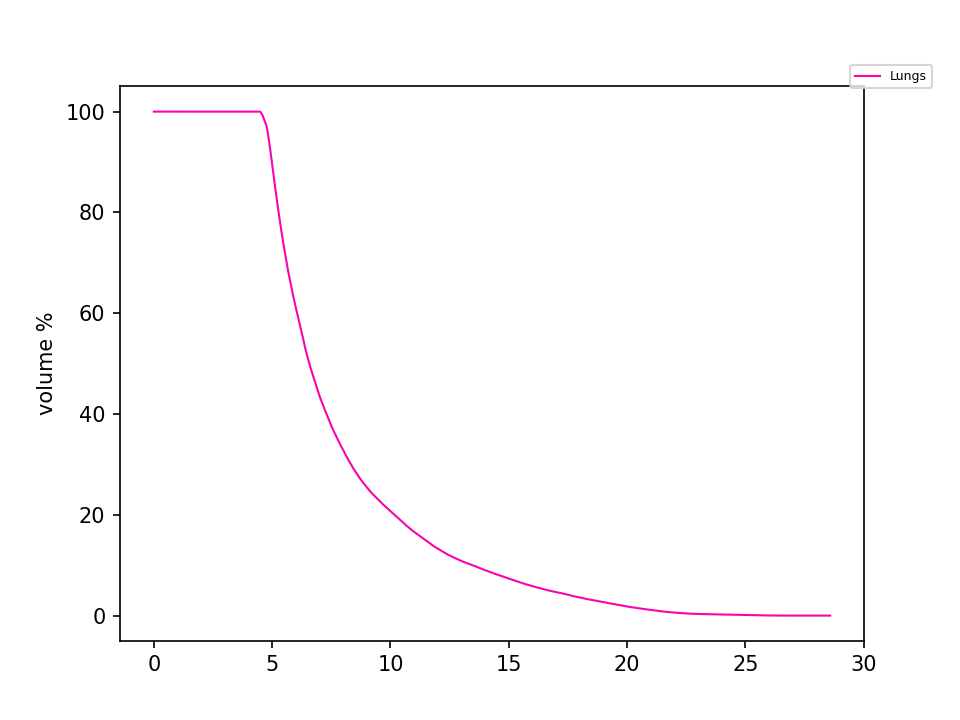

(defaultdict(None, {'Lungs': array([1., 1., 1., ..., 0., 0., 0.])}),
 {'Lungs': 8.015882836100516},
 {'Lungs': 26.72603736307324},
 {'Lungs': 4.847290374411494},
 {'Lungs': 16.67239108130915})

In [196]:
standard_list = ['PTV_Ribs', 'PTV_VExP', 'PTV_SpCord', 'PTV_LN', 'PTV_Spleen', 'PTV_Liver', 'BODY', 'Lungs']
standard_list = ['Lungs']
plot_DVH(plan, standard_list)

Lungs
True mean organ dose is:  7.988167042143717
True max organ dose is:  26.11972649371231


<IPython.core.display.Javascript object>


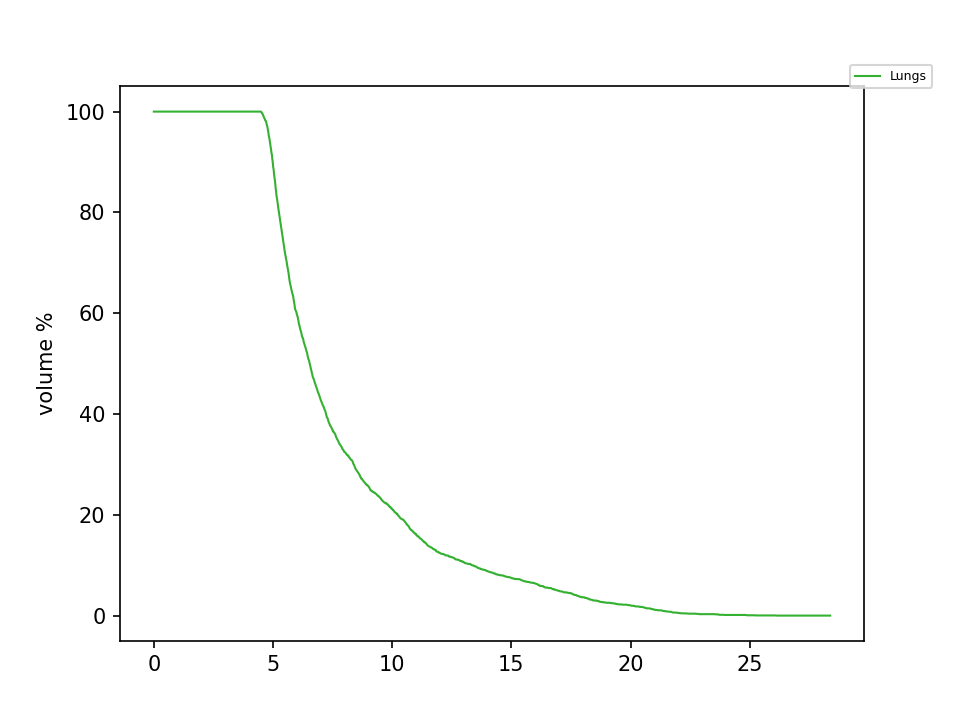

(defaultdict(None, {'Lungs': array([1., 1., 1., ..., 0., 0., 0.])}),
 {'Lungs': 7.988167042143717},
 {'Lungs': 26.11972649371231},
 {'Lungs': 4.840816918198047},
 {'Lungs': 16.92156529763071})

In [206]:
plot_DVH(plan_new, standard_list)

In [289]:
if __name__ == '__main__':
    run_training(train_gan_model = False, input_size = (16, 64, 128, 12), parent_path='Data', training_npy_path = 'Data/npy_dataset/training/' , validation_npy_path = 'Data/npy_dataset/validation/')

NameError: name 'run_training' is not defined

In [43]:
contour_arr_orignal = plan.structures['Ring_1']['contour']

In [54]:
x=np.array([1,2,3])
y=np.array([4,5,6])
z = np.array([7])
xx,yy, zz = np.meshgrid(x,y,z)

In [65]:
dose_plane = dose_vol.interpolating_function(test)

In [46]:
contour_arr_orignal = plan.structures['Ring_1']['contour'][107,:,:]

In [47]:
np.shape(contour_arr_orignal)

(640, 640)

In [67]:
np.shape(dose_plane)

(3, 3)

In [161]:
arrays = [np.random.randn(3, 4) for _ in range(5)]
np.stack(arrays, axis=0).shape
test = np.stack(arrays, axis=0)
test = test>0
test

array([[[ True, False, False, False],
        [False,  True,  True,  True],
        [False,  True,  True,  True]],

       [[False, False, False, False],
        [ True, False, False, False],
        [False,  True, False,  True]],

       [[False, False, False, False],
        [False,  True,  True, False],
        [False,  True, False, False]],

       [[False,  True,  True,  True],
        [False,  True,  True, False],
        [False,  True, False,  True]],

       [[ True, False,  True,  True],
        [ True, False, False, False],
        [False, False,  True,  True]]])

In [164]:
print(test.shape)
(x,y,z) = np.where(test)

(5, 3, 4)


In [5]:
x = np.array([1,2,3])
max(x-2,0)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [274]:
y = 'abd'
y in x

False

In [250]:
data_folder = 'data_Chavez_NEW'
f = loadmat(data_folder)
scan = f['structset_2d_channel']
dose_img = f['doseset_2d']

In [251]:
scan.shape

(28, 128, 256, 13)

In [252]:
dose_img.shape

(28, 128, 256)

In [302]:
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
tf.test.is_built_with_cuda()

False

In [298]:
tf.test.gpu_device_name()

''

In [301]:
print(tf.version)

<module 'tensorflow._api.v2.version' from 'C:\\Users\\Varian600c\\.conda\\envs\\tf-gpu\\lib\\site-packages\\tensorflow\\_api\\v2\\version\\__init__.py'>


BODY
True mean organ dose is:  17.981836
True max organ dose is:  26.973219
PTV_Ribs
True mean organ dose is:  14.219483
True max organ dose is:  24.234566
PTV_VExP
True mean organ dose is:  20.654083
True max organ dose is:  26.973219
PTV_SpCord  not exist
PTV_LN
True mean organ dose is:  17.149914
True max organ dose is:  21.977737
PTV_Spleen
True mean organ dose is:  20.34707
True max organ dose is:  21.066704
PTV_Liver  not exist
Lungs
True mean organ dose is:  8.585459
True max organ dose is:  20.724731
Heart  not exist
Esophagus  not exist
GI_Upper  not exist
Breasts  not exist


<IPython.core.display.Javascript object>


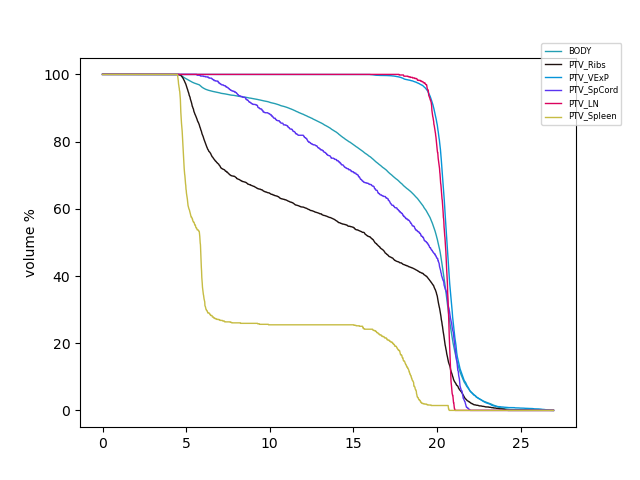

BODY
True mean organ dose is:  14.981835
True max organ dose is:  23.973219
PTV_Ribs
True mean organ dose is:  11.219483
True max organ dose is:  21.234566
PTV_VExP
True mean organ dose is:  17.654083
True max organ dose is:  23.973219
PTV_SpCord  not exist
PTV_LN
True mean organ dose is:  14.149915
True max organ dose is:  18.977737
PTV_Spleen
True mean organ dose is:  17.34707
True max organ dose is:  18.066704
PTV_Liver  not exist
Lungs
True mean organ dose is:  5.585459
True max organ dose is:  17.724731
Heart  not exist
Esophagus  not exist
GI_Upper  not exist
Breasts  not exist


<IPython.core.display.Javascript object>


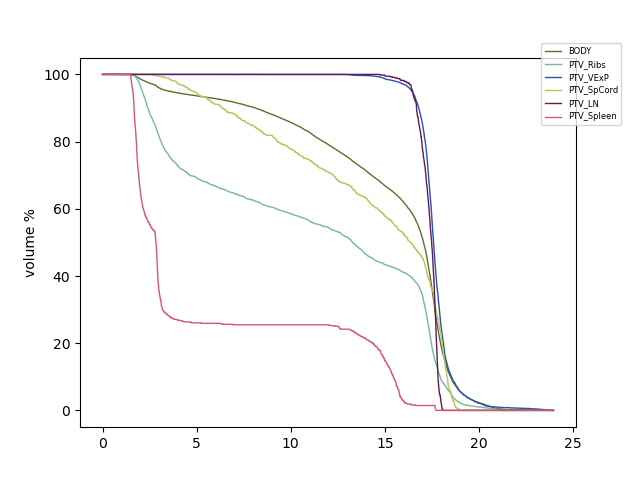

<IPython.core.display.Javascript object>


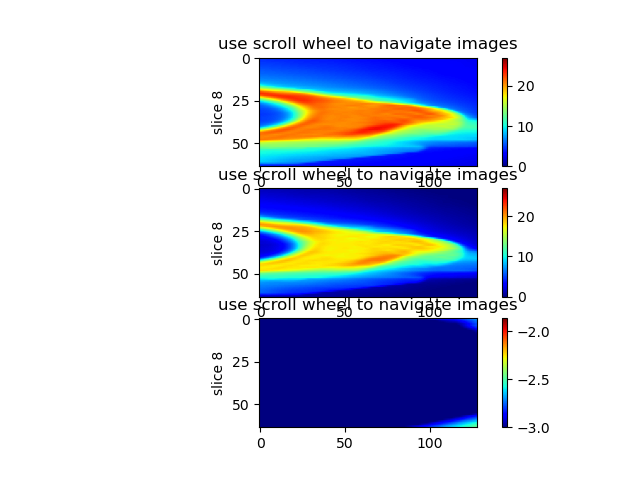

<IPython.core.display.Javascript object>


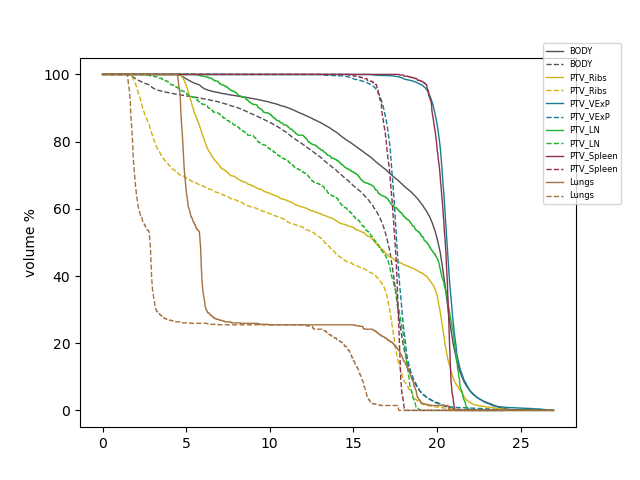

,Organ,Dmean,Dmax,D95,D98,D5,D2
0,BODY,-0.166835,-0.111221,-0.459403,-0.572747,-0.135594,-0.129318
1,PTV_Ribs,-0.210978,-0.123790,-0.587269,-0.613149,-0.139083,-0.136181
2,PTV_VExP,-0.145250,-0.111221,-0.154396,-0.161566,-0.135609,-0.129922
3,PTV_LN,-0.174928,-0.136502,-0.387902,-0.442300,-0.139083,-0.138288
4,PTV_Spleen,-0.147441,-0.142405,-0.153691,-0.157900,-0.143332,-0.142066
5,Lungs,-0.349428,-0.144755,-0.651765,-0.661418,-0.159747,-0.156977


In [8]:
predict_unit_test()

In [4]:
test = []
np.shape(test)

(0,)